In [2]:
import json
import plotly
from ipywidgets import interact, interactive, fixed, interact_manual
from pprint import pprint
 
def simplify_config(game_config: dict) -> dict:
    simple_config = {}
    for config in game_config:
        simple_config[config["NativeClass"]] = {item["ClassName"]: item for item in config["Classes"]}
    return simple_config

CONFIG_LOCATION = "D:\SteamLibrary\steamapps\common\Satisfactory\CommunityResources\Docs\Docs.json"
with open(CONFIG_LOCATION, "r", encoding="utf-16") as f:
    data = f.read()
    BASE_CONFIG = simplify_config(json.loads(data))
    
def standardize(value: str):
    return "_".join(value.replace("-", "_").replace(":", "").split()).lower()

# missing miner, rebar spreadshot
RESOURCE_KEYS = ("Class'/Script/FactoryGame.FGItemDescriptor'", 
                 "Class'/Script/FactoryGame.FGResourceDescriptor'",
                 "Class'/Script/FactoryGame.FGConsumableDescriptor'",
                 "Class'/Script/FactoryGame.FGItemDescriptorBiomass'",
                 "Class'/Script/FactoryGame.FGAmmoTypeProjectile'",
                 "Class'/Script/FactoryGame.FGItemDescriptorNuclearFuel'",
                 "Class'/Script/FactoryGame.FGAmmoTypeInstantHit'")

In [3]:
# TODO: make an intermediate config with cleaned up keys
# material/recipe: internal_name: useful info
import itertools

def get_materials(simple_config: dict) -> list[str]:
    resources = []
    for item in itertools.chain.from_iterable((simple_config[key].values() for key in RESOURCE_KEYS)):
        resources.append(standardize(item["mDisplayName"]))
    return resources

In [106]:
from abc import ABC
from dataclasses import dataclass, fields, make_dataclass
from enum import Enum, auto
from collections import deque
from typing import Optional
from itertools import zip_longest
import plotly.express as px

# TODO: how much of this can be expressed/solved with matrices?

class ConfigurationError(Exception):
    pass

class __MaterialSpec:
    """
    TODO: give this a widget
    """    
    def __add__(self, other):
        if not isinstance(other, type(self)):
            return NotImplemented
        
        result = {}
        for name, value in self:
            result[name] = value + getattr(other, name)
        return type(self)(**result)
    
    def __sub__(self, other):
        if not isinstance(other, type(self)):
            return NotImplemented
        
        result = {}
        for name, value in self:
            result[name] = value - getattr(other, name)
        return type(self)(**result)
    
    def __mul__(self, scalar):
        result = {}
        for name, value in self:
            result[name] = value * scalar 
        return type(self)(**result)
    
    def __iter__(self):
        for f in fields(self):
            yield f.name, getattr(self, f.name)
                       
    def __or__(self, other):
        if isinstance(other, type(self)):
            return type(self)(**{name: value for (name, value), (_, matched_value) in zip(self, other) if matched_value > 0})
        # elif isinstance(other, Material):
        #     return type(self)(**{other.name: getattr(self, other.name)})
        elif isinstance(other, str):
            return type(self)(**{other: getattr(self, other)})
        
        return NotImplemented
    
    def __repr__(self):
        return "\n".join(f"{name}: {value}" for name, value in self if value > 0)

MaterialSpec = make_dataclass("MaterialSpec", [(mat, float, 0) for mat in get_materials(BASE_CONFIG)], bases=(__MaterialSpec,), repr=False)
    
class Recipe:
    name: str
    
    def __init__(self, name: str, ingredients: MaterialSpec, products: MaterialSpec):
        self.ingredients = ingredients
        self.products = products
        self.name = name
        
    def __add__(self, material_spec: MaterialSpec):
        return material_spec + self.products - self.ingredients
    
    def __radd__(self, material_spec: MaterialSpec):
        return self + material_spec
    
    def __rsub__(self, material_spec: MaterialSpec):
        return material_spec + self.ingredients - self.products
    
    def __mul__(self, scalar: float):
        """
        Scale up this recipe
        """
        return type(self)(self.name, self.ingredients * scalar, self.products * scalar)
    
    def __rtruediv__(self, material_spec: MaterialSpec):
        """
        Get the number of iterations of this recipe that can be produced from the given material_spec
        """
        return min(getattr(material_spec, name) / value for name, value in self.ingredients if value > 0)
    
    def __repr__(self):
        ingredients = " ".join(repr(self.ingredients).splitlines())
        products = " ".join(repr(self.products).splitlines())
                
        return f"{ingredients} >> {products}"
        
        
class Machine(ABC):    
    # TODO: weakref these
    input_producers: dict["Machine", str]
    output_consumers: dict["Machine", str]
    
    power_consumption: float
    inputs: int
    outputs: int
    color: str
    
    _color_generator = iter(px.colors.qualitative.Dark24)
    
    def __init__(self, recipe: Recipe):
        inputs = sum(material > 0 for _, material in recipe.ingredients)
        outputs = sum(material > 0 for _, material in recipe.products)
        self.input_producers = {}
        self.output_consumers = {}
        
        if inputs != self.inputs or outputs != self.outputs:
            raise ConfigurationError(f"{self.__class__} must have {self.inputs} inputs and {self.outputs} outputs")
            
        self.recipe = recipe
        
    def __init_subclass__(cls, skip_color=False):
        if not skip_color:
            cls.color = next(cls._color_generator)
        
    def __str__(self):
        return f"<{self.__class__.__name__}: {self.recipe}>"
        
    def __repr__(self):
        return str(self)
        
    def __rshift__(self, material_spec: MaterialSpec):
        """
        Solve for inputs
        Recipe >> MaterialSpec
        """
        # TODO: what should the inverse of div be?
        scale = max(getattr(material_spec, name) / value for name, value in self.recipe.products if value > 0)
        scaled = self.recipe * scale
        return material_spec - scaled
    
    def __lshift__(self, material_spec: MaterialSpec):
        """
        Solve for outputs
        Recipe << MaterialSpec
        """
        scale = material_spec / self.recipe
        scaled = self.recipe * scale
        return material_spec + scaled
        
    def __rrshift__(self, material_spec: MaterialSpec):
        """
        Solve for inputs
        MaterialSpec << Recipe
        """
        return self << material_spec
    
    def __rlshift__(self, material_spec: MaterialSpec):
        """
        Solve for outputs
        MaterialSpec >> Recipe
        """
        return self >> material_spec
        
    def has_input(self, material: str):
        return getattr(self.recipe.ingredients, material) > 0
    
    def has_output(self, material: str):
        return getattr(self.recipe.products, material) > 0
    
    # TODO: there's some serious confusion of responsibilities between this and recipe
    def products(self):
        return [product for product, value in self.recipe.products if value > 0]
    
    def ingredients(self):
        return [ingredient for ingredient, value in self.recipe.ingredients if value > 0]
    
    # TODO: use belt objects instead of bind to produce multiple graphs from the same set of machines
    def bind(self, other: "Machine", material: str):
        """
        Verify that there is a matching input-output pair for these two machines
        
        # TODO: can only handle binding one output to a given machine
        """
        if self.has_output(material) and other.has_input(material):
            other.input_producers[self] = material
            self.output_consumers[other] = material
        elif self.has_input(material) and other.has_output(material):
            self.input_producers[other] = material
            other.output_consumers[self] = material
        else:
            raise ConfigurationError(f"{self} and {other} do not have a matching input and output.")
            
        return self
    
class Process:
    """
    TODO: power
    """
    scale: int
    power: float = 0
    process_root: Machine
    input_materials: MaterialSpec
    output_materials: MaterialSpec
    surplus_materials: MaterialSpec
    
    def __init__(self, process_root: Machine, target_output: MaterialSpec=None, _registry=None):
        # TODO: scale process to desired output
        self.process_root = process_root
        
        if _registry is None:
            self.process_registry = {}
        else:
            self.process_registry = _registry
            
        self.process_registry[process_root] = self

        if len(self.process_root.output_consumers) > 0:
            # TODO: how to deal with cycles?
            # TODO: if input material is the result of an output further up in the process (ie already in registry),
            # TODO: subtract that from sizing
            required_output = sum((self.process_registry[output_consumer].input_materials | bound_material 
                                   for output_consumer, bound_material 
                                   in process_root.output_consumers.items()), MaterialSpec())
            self.input_materials = (process_root >> required_output) | process_root.recipe.ingredients
        else:
            required_output = process_root.recipe.products if target_output is None else target_output | process_root.recipe.products
            self.input_materials = process_root >> required_output
  
        raw_output = self.input_materials >> process_root
        self._required = required_output # for debugging
        self._raw = raw_output
        self.output_materials = raw_output | required_output
        self.surplus_materials = raw_output - required_output
        self.scale = self.input_materials / process_root.recipe
    
    @classmethod
    def from_machines(cls, target_output: MaterialSpec, machines: list[Machine]):
        """
        Builds a process tree from a list of machines
        """        
        output = Aggregator(Recipe("products", target_output, target_output))
        nodes = deque([output])
        visited = set()
        registry = {}

        
        while len(nodes):
            current_node = nodes.popleft()
            visited.add(current_node)
            
            for machine in machines:
                for ingredient in current_node.ingredients():
                    if machine.has_output(ingredient):
                        current_node.bind(machine, ingredient)
                        if machine not in visited:
                            nodes.append(machine)
        
        nodes = deque([output])
        while len(nodes):
            current_node = nodes.popleft()
            
            if not all(oc in registry for oc in current_node.output_consumers):
                for node in current_node.output_consumers:
                    if node not in registry and node not in nodes:
                        nodes.append(node)
                    nodes.append(current_node)       
            else:
                cls(current_node, target_output, registry)
                for node in current_node.input_producers:
                    if node not in registry and node not in nodes:
                        nodes.append(node)
            
        return registry[output]


class VariableOutputMachine(Machine, skip_color=True):
        
    def __init__(self, recipe: Recipe):
        self.outputs = min(sum(material > 0 for _, material in recipe.products), self.outputs)
        
        super().__init__(recipe)
        
class VariableInputMachine(Machine, skip_color=True):
        
    def __init__(self, recipe: Recipe):
        self.inputs = min(sum(material > 0 for _, material in recipe.ingredients), self.inputs)
        
        super().__init__(recipe)
                                                                                  
    
class Constructor(Machine):
    power_consumption = 300
    inputs = 1
    outputs = 1
    
class Assembler(Machine):
    power_consumption = 300
    inputs = 2
    outputs = 1
    
class Manufacturer(VariableInputMachine):
    power_consumption = 300
    inputs = 4
    outputs = 1
    
class Smelter(Machine):
    power_consumption = 300
    inputs = 1
    outputs = 1
    
class Foundry(Machine):
    power_consumption = 300 
    inputs = 2
    outputs = 1
    
class Packager(VariableOutputMachine, VariableInputMachine):
    power_consumption = 300
    inputs = 2
    outputs = 2
    
class Refinery(VariableOutputMachine, VariableInputMachine):
    power_consumption = 300
    inputs = 2
    outputs = 2

# Not yet implemented    
class Extractor(Machine):
    power_consumption = 300
    inputs = 0
    outputs = 1
    
class Blender(Machine):
    power_consumption = 300
    inputs = 2
    outputs = 2
    
    
class Aggregator(Machine):
    """
    Special class to join disjoint trees so that every process can be expressed as a tree, 
    regardless of desired outputs. Can be used, for example, to represent a factory floor as a 'Machine'
    """
    def __init__(self, recipe: Recipe):
        self.inputs = sum(material > 0 for _, material in recipe.ingredients)
        self.outputs = sum(material > 0 for _, material in recipe.products)
        super().__init__(recipe)
        
    
class ParticleAccelerator(Machine):
    power_consumption = 300
    inputs = 2
    outputs = 2

    
# class Blender(Machine):
#     pass


# TODO: merge/split machines producing the same item
# TODO: dummy machine to create tree from disjoint processes

# def optimize_recipe(recipe: Recipe, weights: MaterialSpec):
#     # TODO: consider power
#     # TODO: this will likely be most efficient with pre-processing of the costs of various sub-processes
#     pass

In [107]:
import re

machine_mapping = {"/Game/FactoryGame/Buildable/Factory/AssemblerMk1/Build_AssemblerMk1.Build_AssemblerMk1_C": Assembler, 
 "/Game/FactoryGame/Buildable/Factory/ManufacturerMk1/Build_ManufacturerMk1.Build_ManufacturerMk1_C": Manufacturer, 
 "/Game/FactoryGame/Buildable/Factory/SmelterMk1/Build_SmelterMk1.Build_SmelterMk1_C": Smelter,
 "/Game/FactoryGame/Buildable/Factory/ConstructorMk1/Build_ConstructorMk1.Build_ConstructorMk1_C": Constructor, 
 "/Game/FactoryGame/Buildable/Factory/FoundryMk1/Build_FoundryMk1.Build_FoundryMk1_C": Foundry,
 # "/Game/FactoryGame/Buildable/Factory/HadronCollider/Build_HadronCollider.Build_HadronCollider_C",
 "/Game/FactoryGame/Buildable/Factory/Packager/Build_Packager.Build_Packager_C": Packager,
 "/Game/FactoryGame/Buildable/Factory/OilRefinery/Build_OilRefinery.Build_OilRefinery_C": Refinery}

def make_recipes(simple_config: dict, machine_mapping: dict[str, Machine]) -> list:
    ingredients_pattern = r"\(ItemClass=.*?\.(\w+).*?,Amount=(\d+)\)"
    machines_pattern = fr"({'|'.join(re.escape(m) for m in machine_mapping.keys())})"
    known_crafters = ("Smelter", "Manufacturer", "Assembler", "Packager", "Refinery", "Collider", "Foundry", "Blender", "Constructor")
    
    machines = {}
    material_config = {}
    for key in RESOURCE_KEYS:
        material_config.update(simple_config[key])

    for config in simple_config["Class'/Script/FactoryGame.FGRecipe'"].values():
        machine = re.search(machines_pattern, config["mProducedIn"])
        
        if machine is None:
            continue

        machine = machine_mapping[machine[0]]
            
        # TODO: convert resources to friendly names
        try:
            ingredients = {standardize(material_config[name]["mDisplayName"]): int(amt) for name, amt in re.findall(ingredients_pattern, config["mIngredients"])}
            products = {standardize(material_config[name]["mDisplayName"]): int(amt) for name, amt in re.findall(ingredients_pattern, config["mProduct"])}
            machines[standardize(config["mDisplayName"])] = machine(Recipe(standardize(config["mDisplayName"]), MaterialSpec(**ingredients), MaterialSpec(**products)))
        except Exception as e:
            print(f"missing: {e}")
            print(config)
            print()
        
    return machines

In [108]:
available_machines = dict(sorted(make_recipes(BASE_CONFIG, machine_mapping).items()))
#available_machines

missing: 'BP_ItemDescriptorPortableMiner_C'
{'ClassName': 'Recipe_Alternate_AutomatedMiner_C', 'FullName': 'BlueprintGeneratedClass /Game/FactoryGame/Recipes/AlternateRecipes/New_Update4/Recipe_Alternate_AutomatedMiner.Recipe_Alternate_AutomatedMiner_C', 'mDisplayName': 'Alternate: Automated Miner', 'mIngredients': '((ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Parts/Motor/Desc_Motor.Desc_Motor_C"\',Amount=1),(ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Parts/SteelPipe/Desc_SteelPipe.Desc_SteelPipe_C"\',Amount=4),(ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Parts/IronRod/Desc_IronRod.Desc_IronRod_C"\',Amount=4),(ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Parts/IronPlate/Desc_IronPlate.Desc_IronPlate_C"\',Amount=2))', 'mProduct': '((ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Equipment/PortableMiner/BP_ItemDescriptorPortableMiner.BP_ItemDescriptorPortableMiner_C"\',Amount=1))', 'mManufacturin

In [113]:
import igraph
from igraph import Graph, EdgeSeq
import itertools
import plotly.graph_objects as go
import os
from textwrap import dedent

import math

def make_hover_label(process: Process):
    return dedent(f"""
    {process.process_root.__class__.__name__}<br>
    Recipe: {process.process_root.recipe.name}<br>
    Scale: {process.scale}
    """)


def plot_process(process: Process):
    ordered_vertices = list(process.process_registry.values())
    n_vertices = len(ordered_vertices)
    
    edges = [(ordered_vertices.index(process.process_registry[other]), ordered_vertices.index(self)) for self in ordered_vertices for other in self.process_root.input_producers]

    G = Graph(n_vertices, edges)
    layout = G.layout(Graph.layout_auto)
    Xn, Yn = list(zip(*layout))
    edge_coords = itertools.chain.from_iterable([[(Xn[n], Yn[n]) for n in e] + [(None, None)] for e in edges])
    Xe, Ye = list(zip(*edge_coords))
    
    max_scale = max(n.scale for n in ordered_vertices)
    point_scale = 20
    point_sizes = [(math.tanh(n.scale  / max_scale) + 1) * point_scale for n in ordered_vertices]

    fig = go.Figure()
    fig.add_trace(go.Scatter(
                        x=Xe,
                       y=Ye,
                       mode='lines+markers',
                       hoverinfo='none',
                       marker=dict(
                            symbol="arrow-wide",
                            size=10,
                            color="black",
                            angleref="previous",
                            standoff=point_scale//2
                        ),
                        showlegend=False
                    ),
                    
                 )

    fig.add_trace(go.Scatter(x=Xn,
                      y=Yn,
                      mode='markers',
                      marker=dict(symbol='circle-dot',
                                  size=point_sizes,
                                  color=[m.process_root.color for m in ordered_vertices],
                                ),
                      text=[make_hover_label(v) for v in ordered_vertices],
                      hovertemplate="%{text}<extra></extra>",
                      showlegend=False,
                      )
                 )

    # TODO: better sizing
    fig.update_layout(
        autosize=True,
    )

    fig.show()
    
    
def plot_sankey(process: Process):
    ordered_vertices = list(process.process_registry.values())
    n_vertices = len(ordered_vertices)
    
    edges = [(ordered_vertices.index(process.process_registry[other]), ordered_vertices.index(self)) for self in ordered_vertices for other in self.process_root.input_producers]
    source, target = zip(*edges)
    weights = [1 for _ in edges]
    
    fig = go.Figure()
    fig.add_trace(go.Sankey(link=dict(
        source=source,
        target=target,
        value=weights)))
    fig.show()

# TODO: use plotly tables and link rows to scatter/sankey nodes
def make_row(values: list[str]):
    return "<tr>" + "".join([f"<td>{v}</td>" for v in values]) + "</tr>"

def make_table(headers: list[str], values: list[list[str]]):
    header = make_row(headers)
    rows = "\n".join([make_row(row) for row in values])
    
    return dedent(f"""
    <table>
    <thead>
    {header}
    </thead>
    <tbody>
    {rows}
    </tbody>
    </table>""")

def recipe_summary(process: Process):
    headers = ["Machine Type", "Count", "Recipe", ""]
    rows = []
    for process in process.process_registry.values():
        rows.append([process.process_root.__class__.__name__,
                     process.scale,
                     process.process_root.recipe.name,
                     repr(process.process_root.recipe)])
                     
    return make_table(headers, rows)


def material_summary(process: Process):
    net = MaterialSpec()
    
    for process_node in solution.process_registry.values():
        net = net + process_node.process_root.recipe * process_node.scale
        
    rows = [["Net Input", repr(net*-1)], ["Net Output", repr(net)]]
    return make_table([], rows)
    

missing: 'BP_ItemDescriptorPortableMiner_C'
{'ClassName': 'Recipe_Alternate_AutomatedMiner_C', 'FullName': 'BlueprintGeneratedClass /Game/FactoryGame/Recipes/AlternateRecipes/New_Update4/Recipe_Alternate_AutomatedMiner.Recipe_Alternate_AutomatedMiner_C', 'mDisplayName': 'Alternate: Automated Miner', 'mIngredients': '((ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Parts/Motor/Desc_Motor.Desc_Motor_C"\',Amount=1),(ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Parts/SteelPipe/Desc_SteelPipe.Desc_SteelPipe_C"\',Amount=4),(ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Parts/IronRod/Desc_IronRod.Desc_IronRod_C"\',Amount=4),(ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Parts/IronPlate/Desc_IronPlate.Desc_IronPlate_C"\',Amount=2))', 'mProduct': '((ItemClass=BlueprintGeneratedClass\'"/Game/FactoryGame/Resource/Equipment/PortableMiner/BP_ItemDescriptorPortableMiner.BP_ItemDescriptorPortableMiner_C"\',Amount=1))', 'mManufacturin

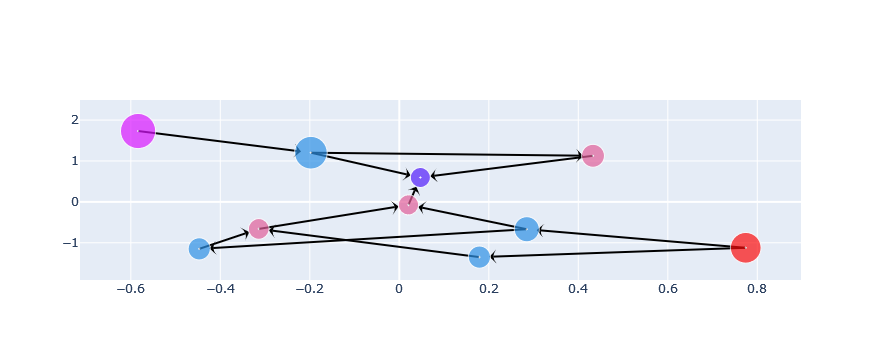

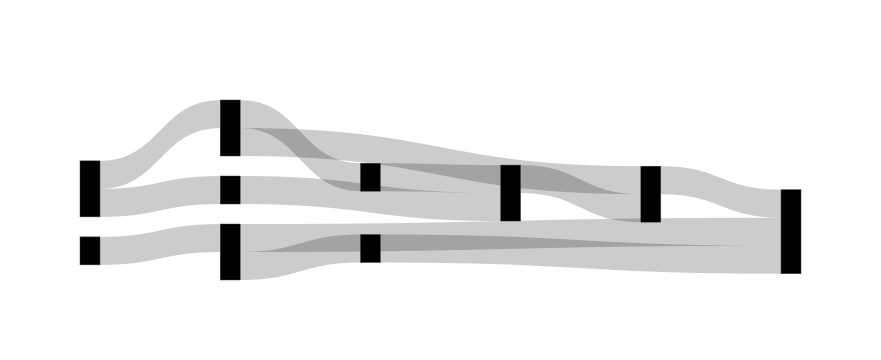

Machine Type,Count,Recipe,
Aggregator,1.0,products,steel_beam: 60 modular_frame: 10 encased_industrial_beam: 60 >> steel_beam: 60 modular_frame: 10 encased_industrial_beam: 60
Assembler,60.0,encased_industrial_beam,concrete: 5 steel_beam: 4 >> encased_industrial_beam: 1
Assembler,5.0,modular_frame,iron_rod: 12 reinforced_iron_plate: 3 >> modular_frame: 2
Constructor,300.0,steel_beam,steel_ingot: 4 >> steel_beam: 1
Assembler,15.0,reinforced_iron_plate,screw: 12 iron_plate: 6 >> reinforced_iron_plate: 1
Foundry,400.0,steel_ingot,coal: 3 iron_ore: 3 >> steel_ingot: 3
Constructor,45.0,screw,iron_rod: 1 >> screw: 4
Constructor,105.0,iron_rod,iron_ingot: 1 >> iron_rod: 1
Constructor,45.0,iron_plate,iron_ingot: 3 >> iron_plate: 2
Smelter,240.0,iron_ingot,iron_ore: 1 >> iron_ingot: 1


Net Input,concrete: 300.0 coal: 1200.0 iron_ore: 1440.0
Net Output,steel_beam: 60.0 modular_frame: 10.0 encased_industrial_beam: 60.0


In [114]:
from IPython.core.display import display, HTML

available_machines = make_recipes(BASE_CONFIG, machine_mapping)
target_product = MaterialSpec(steel_beam=60, encased_industrial_beam=30, modular_frame=10)
solution = Process.from_machines(target_product, [available_machines["heavy_modular_frame"], 
                                                  available_machines["steel_pipe"], 
                                                  available_machines["iron_rod"], 
                                                  available_machines["screw"], 
                                                  available_machines["iron_plate"],
                                                  available_machines["iron_ingot"],
                                                  available_machines["reinforced_iron_plate"], 
                                                  available_machines["steel_beam"],
                                                  available_machines["steel_ingot"],
                                                  available_machines["stator"],
                                                  available_machines["encased_industrial_beam"],
                                                  available_machines["rotor"],
                                                  available_machines["modular_frame"]])
plot_process(solution)
plot_sankey(solution)
display(HTML(recipe_summary(solution)))
display(HTML(material_summary(solution)))


In [112]:
str(net)

'MaterialSpec(uranium_waste=0, plutonium_waste=0, battery=0, aluminum_ingot=0, non_fissile_uranium=0, plutonium_pellet=0, encased_plutonium_cell=0, blue_power_slug=0, iron_rod=0, screw=0, wire=0, yellow_power_slug=0, purple_power_slug=0, concrete=0, silica=0, iron_plate=0, steel_beam=0, color_cartridge=0, power_shard=0, cable=0, modular_frame=0, packaged_fuel=0, packaged_turbofuel=0, iodine_infused_filter=0, gas_filter=0, hub_parts=0, reinforced_iron_plate=0, copper_ingot=0, ficsmas_gift=0, candy_cane=0, ficsmas_tree_branch=0, ficsmas_bow=0, actual_snow=0, ficsmas_wonder_star=0, red_ficsmas_ornament=0, blue_ficsmas_ornament=0, copper_ficsmas_ornament=0, iron_ficsmas_ornament=0, ficsmas_ornament_bundle=0, ficsmas_decoration=0, fused_modular_frame=0, circuit_board=0, copper_sheet=0, crystal_oscillator=0, smart_plating=0, versatile_framework=0, automated_wiring=0, modular_engine=0, packaged_water=0, alien_dna_capsule=0, high_speed_connector=0, motor=0, adaptive_control_unit=0, magnetic_fi